## Canadian Housing Predictions (Model #2) 
## Predictive MultiVariate Autoregression Analysis: VARMAX with Auto Arima

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn import metrics
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

### VARMAX with Auto Arima

Steps: 

1) Read in the data 

2) Clean the data, and slice as needed for dates

3) Perform Stationary Test

4) Perform 1st Differencing

5) Check Stationary Again 

6) Perform Cointegration Test

7) Run Auto Arima 

8) Take the Inverse Difference

9) Run the VARMAX model

10) Plot the Data 

In [2]:
#DATA CLEANING 

In [3]:
#Description: Brining in the data, to produce a combined data frame

df_chartered_bank_i = pd.read_csv('../Resources/Datasets/chartered_bank_interest.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df_chartered_bank_i.head()
# Convert daily data to monthly through the resample function
df_chartered_bank_i.index = pd.to_datetime(df_chartered_bank_i.index)
df_chartered_bank_i_cleaned = df_chartered_bank_i.resample('1Q').mean()
df_chartered_bank_i_cleaned.tail()
df_chartered_bank_i_cleaned.head()
df_chartered_bank_i_cleaned.drop(df_chartered_bank_i_cleaned.columns.difference(['5-year Conventional mortgage', 'Prime rate']), 1, inplace=True)
df_chartered_bank_i_cleaned.head()
df_Residential_mortgages = pd.read_csv('../Resources/Datasets/Credit liabilities of households.csv')
df_Residential_mortgages.head
res_mortgage_transp = df_Residential_mortgages.T
res_mortgage_transp.tail()

# Remove unwanted columns
res_mortgage_transp = res_mortgage_transp.truncate(before='35', after='35', axis=1)
res_mortgage_transp.tail()

# Reset index and change headers
res_mortgage_transp = res_mortgage_transp.reset_index(drop=False)
new_header = res_mortgage_transp.iloc[0] #grab the first row for the header
res_mortgage_transp = res_mortgage_transp[1:] #take the data less the header row
res_mortgage_transp.columns = new_header #set the header row as the dataframe header
res_mortgage_transp.tail()

# Rename the columns
res_mortgage_transp = res_mortgage_transp.rename(columns={'Residential mortgages 14': 'Residential Mortgages'})

# Review data types
res_mortgage_transp.dtypes

# Convert data types to required format
res_mortgage_transp['Date'] = res_mortgage_transp['Date'].astype('datetime64[ns]')
res_mortgage_transp['Residential Mortgages'] = res_mortgage_transp['Residential Mortgages'].astype(float)
res_mortgage_transp.info()

# Convert monthly data to quarterly 
res_mortgage_transp.Date = pd.to_datetime(res_mortgage_transp.Date)

#setting the index to the Date column 
res_mortgage_transp.set_index('Date', inplace=True)
res_mortgage_transp.tail()

#using resample to take Quarterly data 
res_mortgage_cleaned = res_mortgage_transp.resample('1Q').mean()
res_mortgage_cleaned['Residential Mortgages']=res_mortgage_cleaned['Residential Mortgages'].apply(lambda x:round(x,2))
res_mortgage_cleaned.tail()

# House afforability index 
df_House_afford_index  = pd.read_csv('../Resources/Datasets/AffordabilityIndex date.csv')
df_House_afford_index.head()

#here we will be doing some cleaning from this dataset and taking only the Housing Affordability Index
df_House_afford_index = df_House_afford_index.drop(columns=['New housing price index'])
df_House_afford_index.tail()

df_House_afford_index['Date'] = df_House_afford_index['Date'].astype('datetime64[ns]')
df_House_afford_index.dtypes

df_House_afford_index.set_index('Date', inplace=True)
df_House_afford_index_cleaned = df_House_afford_index.resample('1Q').last()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 1 to 381
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   381 non-null    datetime64[ns]
 1   Residential Mortgages  381 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.1 KB


In [4]:
#Description: Cleaning Process for Null Values 

#check null values 
res_mortgage_cleaned.isnull().sum()
#drop null values 

#check again for null values 
df_House_afford_index_cleaned.isnull().sum()

#removing null values 
df_House_afford_index_cleaned = df_House_afford_index_cleaned.dropna().copy()

#check again for null values 
df_House_afford_index_cleaned.isnull().sum()

#check again for null values 
df_chartered_bank_i_cleaned.isnull().sum()

#removing null values 
df_chartered_bank_i_cleaned = df_chartered_bank_i_cleaned.dropna().copy()

#check again for null values 
df_chartered_bank_i_cleaned.isnull().sum()

Prime rate                      0
5-year Conventional mortgage    0
dtype: int64

In [5]:
#Description: Cleaning Process, Slicing for a Specific Date Range 
df_chartered_bank_i_cleaned = df_chartered_bank_i_cleaned['1990-03-31' :'2021-06-30']
print(df_chartered_bank_i_cleaned.head())
print(df_chartered_bank_i_cleaned.tail())

# for Housing Affordability Index
#slice only the dates from 1990-03-31 TO 2021-06-30

df_House_afford_index_cleaned = df_House_afford_index_cleaned['1990-03-31' :'2021-06-30']
print(df_House_afford_index_cleaned.head())
print(df_House_afford_index_cleaned.tail())

# for Residential Mortgages
#we slice only the dates from 1990-03-31 TO 2021-06-30

res_mortgage_cleaned = res_mortgage_cleaned['1990-03-31' :'2021-06-30']
print(res_mortgage_cleaned.head())
print(res_mortgage_cleaned.tail())


#combine into a single dataframe
 
housing_analysis_combined_df = pd.concat([res_mortgage_cleaned, df_House_afford_index_cleaned, df_chartered_bank_i_cleaned], axis="columns", join="inner")

# Sort datetime index in ascending order (past to present)
housing_analysis_combined_df.sort_index(inplace=True)

# Display a few rows
housing_analysis_combined_df.tail()

            Prime rate  5-year Conventional mortgage
date                                                
1990-03-31   13.846154                     12.423077
1990-06-30   14.634615                     14.096154
1990-09-30   14.480769                     13.769231
1990-12-31   13.519231                     12.980769
1991-03-31   11.826923                     11.865385
            Prime rate  5-year Conventional mortgage
date                                                
2020-06-30        2.45                      4.993846
2020-09-30        2.45                      4.854286
2020-12-31        2.45                      4.790000
2021-03-31        2.45                      4.790000
2021-06-30        2.45                      4.790000
            Housing Affordability Index
Date                                   
1990-03-31                        0.479
1990-06-30                        0.527
1990-09-30                        0.494
1990-12-31                        0.467
1991-03-31        

,Residential Mortgages,Housing Affordability Index,Prime rate,5-year Conventional mortgage
2020-06-30,1575288.33,0.300,2.45,4.993846
2020-09-30,1604927.33,0.315,2.45,4.854286
2020-12-31,1639785.00,0.337,2.45,4.790000
2021-03-31,1661491.67,0.347,2.45,4.790000
2021-06-30,1708387.33,0.363,2.45,4.790000


In [6]:
#Description: setting the combined dataframe to df for ease of code 
df = housing_analysis_combined_df
df.head()

,Residential Mortgages,Housing Affordability Index,Prime rate,5-year Conventional mortgage
1990-03-31,229940.67,0.479,13.846154,12.423077
1990-06-30,236727.00,0.527,14.634615,14.096154
1990-09-30,242165.67,0.494,14.480769,13.769231
1990-12-31,246922.00,0.467,13.519231,12.980769
1991-03-31,250729.33,0.434,11.826923,11.865385


In [7]:
# Method used for TimeSeries Evaluation Metrics 

def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [8]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [9]:
df.columns

Index(['Residential Mortgages', 'Housing Affordability Index', 'Prime rate',
       '5-year Conventional mortgage'],
      dtype='object')

In [10]:
for name, column in df[['Residential Mortgages', 'Housing Affordability Index', 'Prime rate',
       '5-year Conventional mortgage']].iteritems():
    Augmented_Dickey_Fuller_Test_func(df[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Residential Mortgages
Test Statistic                   3.125303
p-value                          1.000000
No Lags Used                    10.000000
Number of Observations Used    115.000000
Critical Value (1%)             -3.488535
Critical Value (5%)             -2.887020
Critical Value (10%)            -2.580360
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: Housing Affordability Index
Test Statistic                  -2.565432
p-value                          0.100354
No Lags Used                     7.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: Prime rate
Test Statistic                  -2.109331

In [11]:
X = df[['Residential Mortgages', 'Housing Affordability Index', 'Prime rate',
       '5-year Conventional mortgage']]
nobs = 25
train = df["1996-09-30":"2021-06-30"]
test = df[:nobs]


In [12]:
train_diff = train.diff()
train_diff.dropna(inplace = True)


In [13]:
train_diff.head()

,Residential Mortgages,Housing Affordability Index,Prime rate,5-year Conventional mortgage
1996-12-31,4337.00,-0.024,-1.057692,-0.988462
1997-03-31,3493.66,-0.001,-0.269231,-0.073077
1997-06-30,3923.00,0.009,0.000000,0.346154
1997-09-30,3783.00,-0.013,0.000000,-0.469231
1997-12-31,4289.00,-0.003,0.678571,-0.202747


In [14]:
for name, column in train_diff[['Residential Mortgages', 'Housing Affordability Index', 'Prime rate',
       '5-year Conventional mortgage']].iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Residential Mortgages
Test Statistic                 -0.347186
p-value                         0.918550
No Lags Used                   11.000000
Number of Observations Used    87.000000
Critical Value (1%)            -3.507853
Critical Value (5%)            -2.895382
Critical Value (10%)           -2.584824
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: Housing Affordability Index
Test Statistic                -7.347755e+00
p-value                        1.024919e-10
No Lags Used                   1.000000e+00
Number of Observations Used    9.700000e+01
Critical Value (1%)           -3.499637e+00
Critical Value (5%)           -2.891831e+00
Critical Value (10%)          -2.582928e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Prime rate
Test Statistic                -5.667452e+00
p-

In [15]:
train_diff = train.diff()
train_diff.dropna(inplace = True)


<AxesSubplot:>

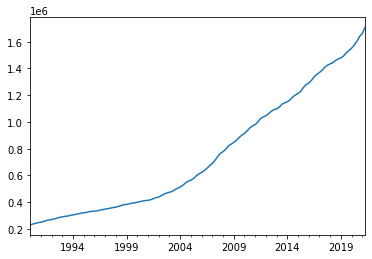

In [16]:
df['Residential Mortgages'].plot()

In [17]:
for name, column in train_diff[['Residential Mortgages', 'Housing Affordability Index', 'Prime rate',
       '5-year Conventional mortgage']].iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Residential Mortgages
Test Statistic                 -0.347186
p-value                         0.918550
No Lags Used                   11.000000
Number of Observations Used    87.000000
Critical Value (1%)            -3.507853
Critical Value (5%)            -2.895382
Critical Value (10%)           -2.584824
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: Housing Affordability Index
Test Statistic                -7.347755e+00
p-value                        1.024919e-10
No Lags Used                   1.000000e+00
Number of Observations Used    9.700000e+01
Critical Value (1%)           -3.499637e+00
Critical Value (5%)           -2.891831e+00
Critical Value (10%)          -2.582928e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Prime rate
Test Statistic                -5.667452e+00
p-

In [18]:
# Transform into a stationary process
df['Residential Mortgages'] = df['Residential Mortgages'].pct_change()
df = df.dropna()
df.head()

,Residential Mortgages,Housing Affordability Index,Prime rate,5-year Conventional mortgage
1990-06-30,0.029513,0.527,14.634615,14.096154
1990-09-30,0.022974,0.494,14.480769,13.769231
1990-12-31,0.019641,0.467,13.519231,12.980769
1991-03-31,0.015419,0.434,11.826923,11.865385
1991-06-30,0.017598,0.434,10.173077,11.269231


In [19]:
for name, column in train_diff[['Residential Mortgages', 'Housing Affordability Index', 'Prime rate',
       '5-year Conventional mortgage']].iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Residential Mortgages
Test Statistic                 -0.347186
p-value                         0.918550
No Lags Used                   11.000000
Number of Observations Used    87.000000
Critical Value (1%)            -3.507853
Critical Value (5%)            -2.895382
Critical Value (10%)           -2.584824
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: Housing Affordability Index
Test Statistic                -7.347755e+00
p-value                        1.024919e-10
No Lags Used                   1.000000e+00
Number of Observations Used    9.700000e+01
Critical Value (1%)           -3.499637e+00
Critical Value (5%)           -2.891831e+00
Critical Value (10%)          -2.582928e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Prime rate
Test Statistic                -5.667452e+00
p-

<AxesSubplot:>

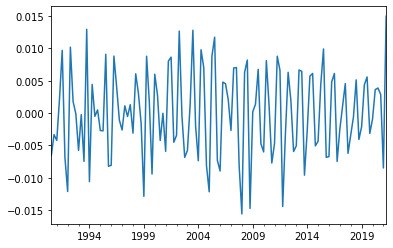

In [20]:
df['Residential Mortgages_diff'] = df['Residential Mortgages'] - df['Residential Mortgages'].shift(1)
df['Residential Mortgages_diff'].dropna().plot()

In [21]:
for name, column in train_diff[['Residential Mortgages', 'Housing Affordability Index', 'Prime rate',
       '5-year Conventional mortgage']].iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Residential Mortgages
Test Statistic                 -0.347186
p-value                         0.918550
No Lags Used                   11.000000
Number of Observations Used    87.000000
Critical Value (1%)            -3.507853
Critical Value (5%)            -2.895382
Critical Value (10%)           -2.584824
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: Housing Affordability Index
Test Statistic                -7.347755e+00
p-value                        1.024919e-10
No Lags Used                   1.000000e+00
Number of Observations Used    9.700000e+01
Critical Value (1%)           -3.499637e+00
Critical Value (5%)           -2.891831e+00
Critical Value (10%)          -2.582928e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Prime rate
Test Statistic                -5.667452e+00
p-

In [22]:
n=7

df['Residential Mortgages_diff'] = df['Residential Mortgages'] - df['Residential Mortgages'].shift(n)
 

In [23]:
for name, column in train_diff[['Residential Mortgages', 'Housing Affordability Index', 'Prime rate',
       '5-year Conventional mortgage']].iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Residential Mortgages
Test Statistic                 -0.347186
p-value                         0.918550
No Lags Used                   11.000000
Number of Observations Used    87.000000
Critical Value (1%)            -3.507853
Critical Value (5%)            -2.895382
Critical Value (10%)           -2.584824
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: Housing Affordability Index
Test Statistic                -7.347755e+00
p-value                        1.024919e-10
No Lags Used                   1.000000e+00
Number of Observations Used    9.700000e+01
Critical Value (1%)           -3.499637e+00
Critical Value (5%)           -2.891831e+00
Critical Value (10%)          -2.582928e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Prime rate
Test Statistic                -5.667452e+00
p-

In [24]:
df['Residential Mortgages_diff'] = np.log(df['Residential Mortgages'])

In [25]:
 # Calculate the square root of the adjusted close prices
df['Residential Mortgages_diff'] = np.sqrt(df['Residential Mortgages'])

In [26]:
# Calculate the cubed root of the adjusted close prices
df['Residential Mortgages_diff'] = np.cbrt(df['Residential Mortgages'])
df['Residential Mortgages_diff']

1990-06-30    0.309034
1990-09-30    0.284281
1990-12-31    0.269807
1991-03-31    0.248897
1991-06-30    0.260109
                ...   
2020-06-30    0.246252
2020-09-30    0.265971
2020-12-31    0.279007
2021-03-31    0.236557
2021-06-30    0.304470
Freq: Q-DEC, Name: Residential Mortgages_diff, Length: 125, dtype: float64

In [27]:
df['Residential Mortgages_diff'] = df['Residential Mortgages'].ewm(alpha=1).mean()
df['Residential Mortgages_diff']


1990-06-30    0.029513
1990-09-30    0.022974
1990-12-31    0.019641
1991-03-31    0.015419
1991-06-30    0.017598
                ...   
2020-06-30    0.014933
2020-09-30    0.018815
2020-12-31    0.021719
2021-03-31    0.013238
2021-06-30    0.028225
Freq: Q-DEC, Name: Residential Mortgages_diff, Length: 125, dtype: float64

In [28]:
for name, column in train_diff[['Residential Mortgages', 'Housing Affordability Index', 'Prime rate',
       '5-year Conventional mortgage']].iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Residential Mortgages
Test Statistic                 -0.347186
p-value                         0.918550
No Lags Used                   11.000000
Number of Observations Used    87.000000
Critical Value (1%)            -3.507853
Critical Value (5%)            -2.895382
Critical Value (10%)           -2.584824
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: Housing Affordability Index
Test Statistic                -7.347755e+00
p-value                        1.024919e-10
No Lags Used                   1.000000e+00
Number of Observations Used    9.700000e+01
Critical Value (1%)           -3.499637e+00
Critical Value (5%)           -2.891831e+00
Critical Value (10%)          -2.582928e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Prime rate
Test Statistic                -5.667452e+00
p-

In [29]:
df['Residential Mortgages_diff']

1990-06-30    0.029513
1990-09-30    0.022974
1990-12-31    0.019641
1991-03-31    0.015419
1991-06-30    0.017598
                ...   
2020-06-30    0.014933
2020-09-30    0.018815
2020-12-31    0.021719
2021-03-31    0.013238
2021-06-30    0.028225
Freq: Q-DEC, Name: Residential Mortgages_diff, Length: 125, dtype: float64

<AxesSubplot:title={'center':'Exponentially Weighted Average'}>

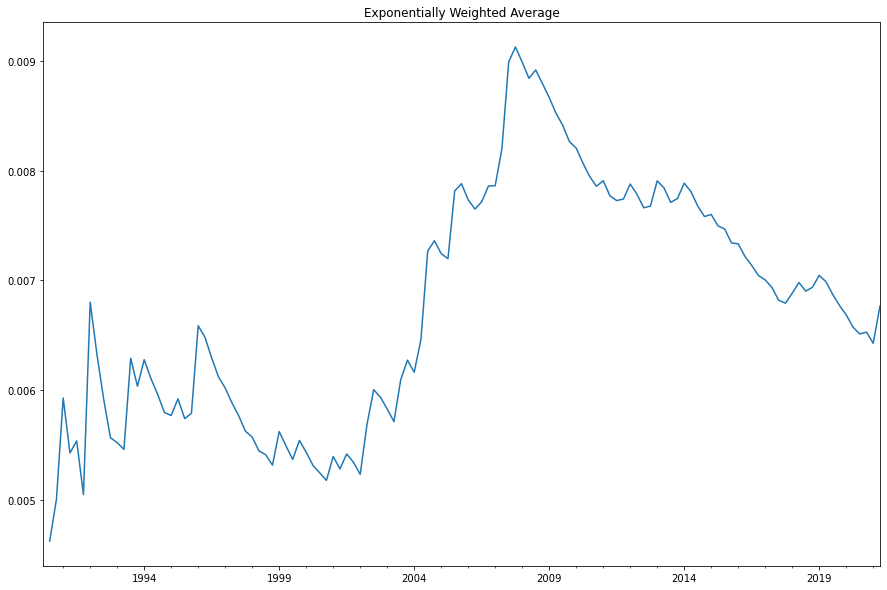

In [30]:
# Use `ewm` to calculate the rolling window
df['Residential Mortgages_diff'] = df['Residential Mortgages_diff'].ewm(com=None, span=None, halflife=21).std()
 
df['Residential Mortgages_diff'].plot(figsize=(15,10), title='Exponentially Weighted Average')

In [31]:
df.drop(columns=['Residential Mortgages'], inplace=True)
df

,Housing Affordability Index,Prime rate,5-year Conventional mortgage,Residential Mortgages_diff
1990-06-30,0.527,14.634615,14.096154,NaN
1990-09-30,0.494,14.480769,13.769231,0.004624
1990-12-31,0.467,13.519231,12.980769,0.005004
1991-03-31,0.434,11.826923,11.865385,0.005928
1991-06-30,0.434,10.173077,11.269231,0.005427
...,...,...,...,...
2020-06-30,0.300,2.450000,4.993846,0.006575
2020-09-30,0.315,2.450000,4.854286,0.006512
2020-12-31,0.337,2.450000,4.790000,0.006529
2021-03-31,0.347,2.450000,4.790000,0.006427


In [32]:
df

,Housing Affordability Index,Prime rate,5-year Conventional mortgage,Residential Mortgages_diff
1990-06-30,0.527,14.634615,14.096154,NaN
1990-09-30,0.494,14.480769,13.769231,0.004624
1990-12-31,0.467,13.519231,12.980769,0.005004
1991-03-31,0.434,11.826923,11.865385,0.005928
1991-06-30,0.434,10.173077,11.269231,0.005427
...,...,...,...,...
2020-06-30,0.300,2.450000,4.993846,0.006575
2020-09-30,0.315,2.450000,4.854286,0.006512
2020-12-31,0.337,2.450000,4.790000,0.006529
2021-03-31,0.347,2.450000,4.790000,0.006427


In [33]:
df = df.rename(columns={
    "Residential Mortgages_diff": "Residential Mortgages",
     
})
df

,Housing Affordability Index,Prime rate,5-year Conventional mortgage,Residential Mortgages
1990-06-30,0.527,14.634615,14.096154,NaN
1990-09-30,0.494,14.480769,13.769231,0.004624
1990-12-31,0.467,13.519231,12.980769,0.005004
1991-03-31,0.434,11.826923,11.865385,0.005928
1991-06-30,0.434,10.173077,11.269231,0.005427
...,...,...,...,...
2020-06-30,0.300,2.450000,4.993846,0.006575
2020-09-30,0.315,2.450000,4.854286,0.006512
2020-12-31,0.337,2.450000,4.790000,0.006529
2021-03-31,0.347,2.450000,4.790000,0.006427


In [34]:
for name, column in train_diff[['Residential Mortgages', 'Housing Affordability Index', 'Prime rate',
       '5-year Conventional mortgage']].iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Residential Mortgages
Test Statistic                 -0.347186
p-value                         0.918550
No Lags Used                   11.000000
Number of Observations Used    87.000000
Critical Value (1%)            -3.507853
Critical Value (5%)            -2.895382
Critical Value (10%)           -2.584824
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: Housing Affordability Index
Test Statistic                -7.347755e+00
p-value                        1.024919e-10
No Lags Used                   1.000000e+00
Number of Observations Used    9.700000e+01
Critical Value (1%)           -3.499637e+00
Critical Value (5%)           -2.891831e+00
Critical Value (10%)          -2.582928e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Prime rate
Test Statistic                -5.667452e+00
p-

In [35]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df): 
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [36]:
cointegration_test(train_diff[['Residential Mortgages', 'Housing Affordability Index', 'Prime rate',
       '5-year Conventional mortgage']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Residential Mortgages >  86.01     > 40.1749   =>   True
Housing Affordability Index >  32.53     > 24.2761   =>   True
Prime rate >  13.47     > 12.3212   =>   True
5-year Conventional mortgage >  0.69      > 4.1296    =>   False


In [37]:
from pmdarima import auto_arima


In [38]:
pq = []
for name, column in train_diff[[ 'Residential Mortgages', 'Housing Affordability Index', 'Prime rate',
       '5-year Conventional mortgage']].iteritems():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(train_diff[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Residential Mortgages
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1971.660, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1991.314, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1990.857, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1970.932, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1989.811, Time=0.00 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1970.440, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1968.939, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1903.270, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1935.756, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1899.217, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1927.940, Time=0.10 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1900.553, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1900.033, Time=0.62 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=19

In [39]:
#Printing the Optimal order for each column
#this is the output of Auto-ARIMA

pq

[(3, 1, 2), (0, 0, 2), (1, 0, 0), (3, 0, 0)]

In [40]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_res[str(col)+'_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [41]:
pq

[(3, 1, 2), (0, 0, 2), (1, 0, 0), (3, 0, 0)]

In [42]:
# model = VARMAX(train_diff[['Residential Mortgages', 'Housing Affordability Index', 'Prime rate',
#        '5-year Conventional mortgage'  ]], order=(i[0],i[2])).fit( disp=False)
# result = model.forecast(steps = 30)
# inv_res = inverse_diff(df, result)
# inv_res.head()

In [43]:
df_results_moni = pd.DataFrame(columns=['p', 'q','RMSE Residential Mortgages','RMSE Housing Affordability Index','RMSE Prime rate','RMSE 5-year Conventional mortgage'])
print('Grid Search Started')
start = timer()
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(train_diff[['Residential Mortgages', 'Housing Affordability Index', 'Prime rate',
       '5-year Conventional mortgage'  ]], order=(i[0],i[2])).fit( disp=False)
        result = model.forecast(steps = 5)
        inv_res = inverse_diff(df, result)
        df_results_moni = df_results_moni.append({'p': i[0], 'q': i[2], }, ignore_index=True)
end = timer()
print(f' Total time taken to complete grid search in seconds: {(end - start)}')

Grid Search Started
 Running for (3, 1, 2)
 Running for (0, 0, 2)
 Running for (1, 0, 0)
 Running for (3, 0, 0)
 Total time taken to complete grid search in seconds: 10.900103900000001


In [44]:
#df_results_moni

In [45]:
# Housing_Rmse = np.sqrt(metrics.mean_squared_error(inv_res["Housing Affordability Index"], inv_res["Housing Affordability Index_1st_inv_diff"]))
# Opensrmse

In [46]:
inv_res

,Residential Mortgages,Housing Affordability Index,Prime rate,5-year Conventional mortgage,Housing Affordability Index_1st_inv_diff,Prime rate_1st_inv_diff,5-year Conventional mortgage_1st_inv_diff,Residential Mortgages_1st_inv_diff
2021-09-30,29428.965031,0.002964,-0.011823,0.027787,0.365964,2.438177,4.817787,29428.971797
2021-12-31,17006.950454,0.005157,-0.171678,-0.141543,0.371121,2.266499,4.676244,46435.922251
2022-03-31,18751.801595,-0.005619,-0.338335,-0.108864,0.365502,1.928164,4.567380,65187.723846
2022-06-30,19775.897697,-0.004139,-0.276501,-0.023871,0.361363,1.651664,4.543508,84963.621543
2022-09-30,18744.330514,0.000114,-0.170971,-0.079874,0.361477,1.480692,4.463635,103707.952058


In [47]:
#drop Residential Mortgages because it is non-stationary data 
inv_res.drop(columns=['Residential Mortgages', 'Residential Mortgages_1st_inv_diff'])

,Housing Affordability Index,Prime rate,5-year Conventional mortgage,Housing Affordability Index_1st_inv_diff,Prime rate_1st_inv_diff,5-year Conventional mortgage_1st_inv_diff
2021-09-30,0.002964,-0.011823,0.027787,0.365964,2.438177,4.817787
2021-12-31,0.005157,-0.171678,-0.141543,0.371121,2.266499,4.676244
2022-03-31,-0.005619,-0.338335,-0.108864,0.365502,1.928164,4.567380
2022-06-30,-0.004139,-0.276501,-0.023871,0.361363,1.651664,4.543508
2022-09-30,0.000114,-0.170971,-0.079874,0.361477,1.480692,4.463635


In [48]:
# from above example we can see that p=0 and q=2 gives least RMSE
model = VARMAX(train_diff[[ 'Residential Mortgages', 'Housing Affordability Index', 'Prime rate',
       '5-year Conventional mortgage' ]], order=(0,2)).fit( disp=False)
result = model.forecast(steps = 5)

In [49]:
result

,Residential Mortgages,Housing Affordability Index,Prime rate,5-year Conventional mortgage
2021-09-30,29090.927205,0.013725,0.163504,0.886492
2021-12-31,631.744537,0.006152,-0.414617,-0.086861
2022-03-31,13820.441009,0.000666,-0.035862,-0.016202
2022-06-30,13820.441009,0.000666,-0.035862,-0.016202
2022-09-30,13820.441009,0.000666,-0.035862,-0.016202


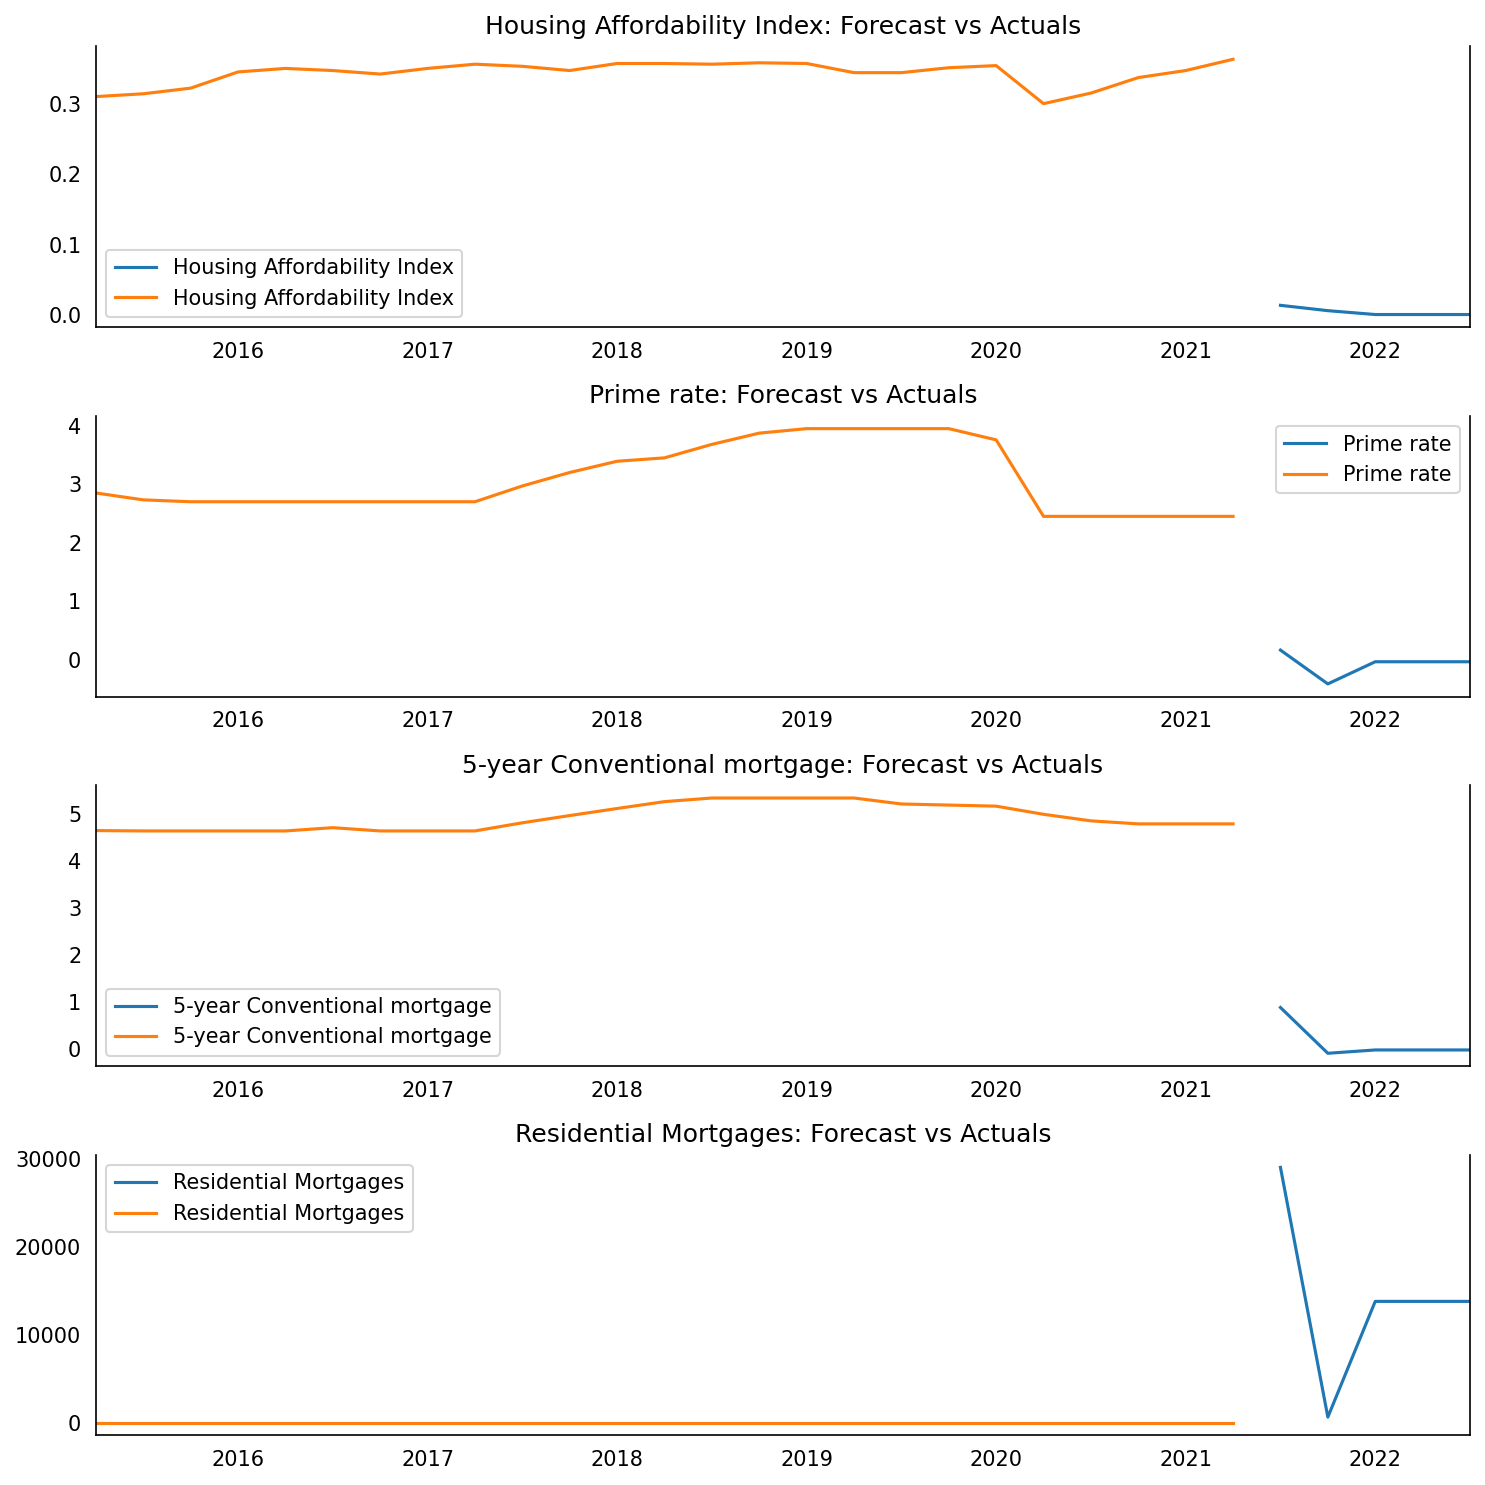

In [56]:
# plot forecast vs. actuals
fig, axes = plt.subplots(nrows=int(len(df.columns)), ncols=1, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    result[col].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df[col ][-nobs:].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=10)

plt.tight_layout()

In [51]:
from sklearn.metrics import mean_squared_error
# # Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# mse = mean_squared_error(
#     inv_res["Residential Mortgages"],
#     inv_res["Residential Mortgages_1st_inv_diff"]
# )

# # Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
# rmse = np.sqrt(mse)
# print(f"Residential Mortgages: Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

In [52]:
#Housing Affordability Index
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    inv_res["Housing Affordability Index"],
    inv_res["Housing Affordability Index_1st_inv_diff"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Housing Affordability Index: Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Housing Affordability Index: Out-of-Sample Root Mean Squared Error (RMSE): 0.3654050642958553


In [53]:
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    inv_res["Prime rate"],
    inv_res["Prime rate_1st_inv_diff"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Prime rate_1st_inv_diff: Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Prime rate_1st_inv_diff: Out-of-Sample Root Mean Squared Error (RMSE): 2.169333490893821


In [54]:
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    inv_res["5-year Conventional mortgage"],
    inv_res["5-year Conventional mortgage_1st_inv_diff"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"5-year Conventional mortgage: Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

5-year Conventional mortgage: Out-of-Sample Root Mean Squared Error (RMSE): 4.68031742220557


In [55]:
# LIST ALL THE RMSE HERE 